In [6]:
from langgraph.graph import StateGraph, START, END
from langchain_google_genai import ChatGoogleGenerativeAI
from typing import TypedDict, Literal
import sqlite3
import json
import os
import re
import sys
from dotenv import load_dotenv
import chromadb

In [7]:
# Add parent directory to path for imports
# OR Method 2: Simple relative paths
sys.path.append('..')  # Go up one level
sys.path.append('.')   # Current directory

# Load environment variables
load_dotenv()

model = ChatGoogleGenerativeAI(
    model='gemini-2.5-flash',
    google_api_key=os.getenv('GEMINI_API_KEY')
)

In [8]:
class AgentState(TypedDict):
    user_query: str
    sql_query: str
    validation_passed: Literal["passed", "failed"]
    feedback: str
    result: str
    iteration_count: int
    query_keywords: list
    relevant_schema: dict
    business_domains: list


In [9]:
def get_user_query(_: AgentState) -> AgentState:
    user_query = input("Enter your question: ")
    return {
        "user_query": user_query,
        "sql_query": "",
        "validation_passed": "failed",
        "feedback": "",
        "result": "",
        "iteration_count": 0,
        "query_keywords": [],
        "relevant_schema": {},
        "business_domains": []
    }

In [10]:
def analyze_query_intent(state: AgentState) -> AgentState:
    prompt = f"""
    Analyze this user query and extract relevant information for database search:
    
    USER QUERY: "{state['user_query']}"
    
    Your task:
    1. Extract key keywords, entities, and concepts
    2. Identify potential business domains from: [Food, Desserts, Recipes, Geography, Timing]
    3. Focus on: ingredients, regions, states, preparation time, cooking time, diet, flavors
    
    Return ONLY a JSON object with this structure:
    {{
        "keywords": ["keyword1", "keyword2", ...],
        "domains": ["domain1", "domain2", ...]
    }}
    """
    
    try:
        response = model.invoke(prompt)
        import json as json_lib
        result = json_lib.loads(response.content.strip())
        
        print(f"🔍 Query Analysis:")
        print(f"   Keywords: {result['keywords']}")
        print(f"   Domains: {result['domains']}")
        
        return {
            **state,
            "query_keywords": result['keywords'],
            "business_domains": result['domains']
        }
    except Exception as e:
        print(f"❌ Error in query analysis: {e}")
        simple_keywords = state['user_query'].lower().split()
        return {
            **state,
            "query_keywords": simple_keywords,
            "business_domains": ["Food", "Desserts"]
        }

In [11]:
def retrieve_relevant_schema(state: AgentState) -> AgentState:
    try:
        # ChromaDB path relative to project root
        chroma_path = os.path.join(os.path.dirname(__file__), '..', 'chroma_db')
        client = chromadb.PersistentClient(path=chroma_path)
        collection = client.get_collection("schema_knowledge_base")
        
        search_terms = " ".join(state['query_keywords'] + state['business_domains'])
        
        results = collection.query(
            query_texts=[search_terms],
            n_results=5
        )
        
        relevant_columns = {}
        table_info = {}
        
        for i, doc in enumerate(results['documents'][0]):
            metadata = results['metadatas'][0][i]
            
            if metadata['column'] == 'all':
                table_info = {
                    'description': "Contains Indian dessert information",
                    'domain': metadata['domain']
                }
            else:
                col_name = metadata['column']
                relevant_columns[col_name] = {
                    'type': metadata['type'],
                    'description': doc.split('Description: ')[1].split('\n')[0] if 'Description: ' in doc else '',
                    'domain': metadata['domain']
                }
        
        relevant_schema = {
            'tables': ['indian_desserts'],
            'columns': relevant_columns,
            'table_info': table_info
        }
        
        print(f"📚 Retrieved Relevant Schema:")
        print(f"   Tables: {relevant_schema['tables']}")
        print(f"   Columns: {list(relevant_columns.keys())}")
        
        return {
            **state,
            "relevant_schema": relevant_schema
        }
        
    except Exception as e:
        print(f"❌ Error retrieving schema: {e}")
        # Fallback to full schema from data folder
        metadata_path = os.path.join(os.path.dirname(__file__), '..', 'data', 'indian_deserts.json')
        with open(metadata_path) as f:
            full_metadata = json.load(f)
        return {
            **state,
            "relevant_schema": {
                'tables': ['indian_desserts'],
                'columns': full_metadata['indian_desserts']['columns'],
                'table_info': {'description': 'Fallback: full schema loaded'}
            }
        }

In [12]:
def generate_sql(state: AgentState):
    schema_desc = []
    for col_name, col_info in state['relevant_schema']['columns'].items():
        schema_desc.append(
            f"- {col_name} ({col_info['type']}): {col_info.get('description', '')}"
        )
    schema_text = "\n".join(schema_desc)
    
    retrieval_context = f"""
    Based on your query about: {', '.join(state['query_keywords'])}
    I've retrieved these relevant columns: {', '.join(state['relevant_schema']['columns'].keys())}
    """

    prompt = f"""
    You are a SQL expert. Generate a valid SQLite query for the user's request.

    **Table:** indian_desserts
    **Relevant Schema (based on your query):**
    {schema_text}

    **Query Context:**
    {retrieval_context}

    **User Query:** {state['user_query']}
    **Validator Feedback:** {state.get('feedback', 'None')}

    **CRITICAL INSTRUCTIONS:**
    - Return ONLY the raw SQL query with NO extra text
    - Do NOT include markdown code blocks or backticks
    - Do NOT end the query with a semicolon
    - Use proper SQLite syntax
    - **When asked about desserts, ALWAYS add: WHERE course = 'dessert'**
    - Use ONLY the columns I provided above
    """

    response = model.invoke(prompt)
    
    sql_query = response.content.strip()
    sql_query = re.sub(r'^```sql\s*', '', sql_query, flags=re.IGNORECASE)
    sql_query = re.sub(r'^```\s*', '', sql_query)
    sql_query = re.sub(r'```$', '', sql_query)
    sql_query = re.sub(r'^\s*sql\s*', '', sql_query, flags=re.IGNORECASE)
    sql_query = re.sub(r'^\s*sqlite\s*', '', sql_query, flags=re.IGNORECASE)
    sql_query = sql_query.rstrip('; \n\t')

    print(f"\n🧠 Generated SQL (Iteration {state['iteration_count']}): {sql_query}")
    
    return {
        **state, 
        "sql_query": sql_query,
        "iteration_count": state["iteration_count"] + 1
    }

In [13]:
def validate_sql(state: AgentState) -> AgentState:
    sql_query = state["sql_query"]
    validation_passed = True
    feedback = ""

    # Load full schema for validation from data folder
    metadata_path = os.path.join(os.path.dirname(__file__), '..', 'data', 'indian_deserts.json')
    with open(metadata_path) as f:
        full_metadata = json.load(f)
    valid_columns = set(full_metadata["indian_desserts"]["columns"].keys())

    prompt = f"""
    Extract ONLY the column names from this SQL query:
    ---
    {sql_query}
    ---
    Rules:
    - Include columns from SELECT and WHERE clauses.
    - Ignore SQL keywords, table names, and string literals.
    - For SELECT *, return *.
    - Output comma-separated column names only.
    """

    try:
        response = model.invoke(prompt)
        extracted_cols_list = [
            c.strip().lower() for c in response.content.split(",") if c.strip()
        ]
        extracted_columns = set(extracted_cols_list)

        if "*" in extracted_columns:
            feedback = "Query uses SELECT *, which is acceptable."
        else:
            invalid_columns = extracted_columns - valid_columns
            if invalid_columns:
                validation_passed = False
                feedback = (
                    f"Invalid columns found: {', '.join(invalid_columns)}. "
                    f"Valid columns are: {', '.join(valid_columns)}."
                )
            else:
                feedback = "All columns are valid."

    except Exception as e:
        validation_passed = False
        feedback = f"Validation error: {str(e)}"

    print(f"\n🧾 Validation Feedback: {feedback}")

    return {
        **state,
        "validation_passed": "passed" if validation_passed else "failed",
        "feedback": feedback,
    }

In [14]:
def execute_sql(state: AgentState):
    # Database path in data folder
    db_path = os.path.join(os.path.dirname(__file__), '..', 'data', 'desserts.db')

    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    try:
        cursor.execute(state["sql_query"])
        rows = cursor.fetchall()
        result = rows if rows else "No results found."
        print("📊 Query Result:", result)
    except Exception as e:
        result = f"Execution Error: {e}"
        print(result)
    finally:
        conn.close()

    return {**state, "result": str(result)}

def validation_check(state: AgentState):
    return "execute_sql" if state["validation_passed"] == "passed" else "generate_sql"

In [15]:
graph = StateGraph(AgentState)

graph.add_node("get_user_query", get_user_query)
graph.add_node("analyze_query_intent", analyze_query_intent)
graph.add_node("retrieve_relevant_schema", retrieve_relevant_schema)
graph.add_node("generate_sql", generate_sql)
graph.add_node("validate_sql", validate_sql)
graph.add_node("execute_sql", execute_sql)

graph.add_edge(START, "get_user_query")
graph.add_edge("get_user_query", "analyze_query_intent")
graph.add_edge("analyze_query_intent", "retrieve_relevant_schema")
graph.add_edge("retrieve_relevant_schema", "generate_sql")
graph.add_edge("generate_sql", "validate_sql")

graph.add_conditional_edges(
    "validate_sql", 
    validation_check,
    {
        "execute_sql": "execute_sql",
        "generate_sql": "generate_sql"
    }
)

graph.add_edge("execute_sql", END)

workflow = graph.compile()

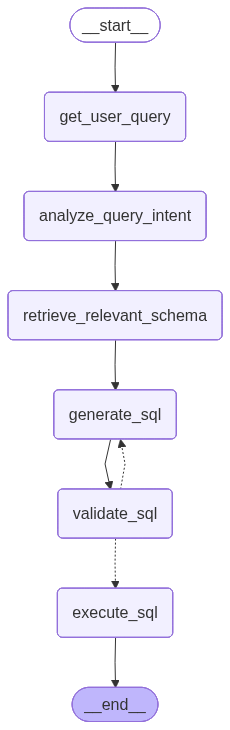

In [16]:
workflow

In [17]:

if __name__ == "__main__":
    # Check if knowledge base exists
    try:
        chroma_path = os.path.join(os.path.dirname(__file__), '..', 'chroma_db')
        client = chromadb.PersistentClient(path=chroma_path)
        client.get_collection("schema_knowledge_base")
        print("✅ Knowledge base loaded")
    except:
        print("❌ Knowledge base not found. Please run create_knowledge_base.py first")
        exit(1)
    
    print("🍰 Welcome to the Enhanced Indian Desserts SQL Agent!")
    
    initial_state = {
        "user_query": "",
        "sql_query": "",
        "validation_passed": "failed",
        "feedback": "",
        "result": "",
        "iteration_count": 0,
        "query_keywords": [],
        "relevant_schema": {},
        "business_domains": []
    }

    result = workflow.invoke(initial_state)

    print("\n" + "="*50)
    print("👤 User Query: ", result["user_query"])
    print("🎯 Final Query:", result["sql_query"])
    print("📈 Final Result:", result["result"])

❌ Knowledge base not found. Please run create_knowledge_base.py first
🍰 Welcome to the Enhanced Indian Desserts SQL Agent!
❌ Error in query analysis: Expecting value: line 1 column 1 (char 0)
❌ Error retrieving schema: name '__file__' is not defined


NameError: name '__file__' is not defined